## Example PCMCI

# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat
import statsmodels.api as sm
from scipy import signal
from scipy import stats

## Step 1) Load the data + Extract regions of interest


In [2]:
bk_sic = iris.load_cube('data/bk_sic.nc', "sic")
nh_spv = iris.load_cube('data/nh_spv_uwnd.nc', "uwnd")
np_slp = iris.load_cube('data/np_slp.nc', "slp")
ural_slp = iris.load_cube('data/ural_slp.nc', "slp")

In [3]:
# make seasonal means

def do_mean_over_months(data_cube, list_months):

    # extract months of interest
    ond_constraint = iris.Constraint(month=lambda v: v in list_months) # ['Oct','Nov', 'Dec'])
    precip_ond = data_cube.extract(ond_constraint)

    # create the mean
    precip_ond_mean = precip_ond.aggregated_by(['year'],iris.analysis.MEAN)
    
    return precip_ond_mean

In [12]:
bk = do_mean_over_months(bk_sic, ['Oct','Nov', 'Dec']) 
spv = do_mean_over_months(nh_spv, ['Jan','Feb', 'Mar'])
ural = do_mean_over_months(ural_slp, ['Oct','Nov', 'Dec'])
pac = do_mean_over_months(np_slp, ['Oct','Nov', 'Dec'])

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 2:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 2:
  #000: H5A.c line 528 in H5Ao

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Ao

### plot the time-series

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

IrisError: Cannot plot against time in a non-standard calendar, because "nc_time_axis" is not available :  Install the package from https://github.com/SciTools/nc-time-axis to enable this usage.

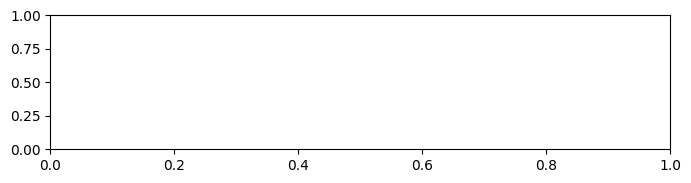

In [8]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(411)
qplt.plot(bk)
plt.title('BK-SIC')

plt.subplot(412)
qplt.plot(ural)
plt.title('Ural_slp')

plt.subplot(413)
qplt.plot(pac)
plt.title('NP_slp')

plt.subplot(414)
qplt.plot(spv)
plt.title('NH-SPV')
plt.tight_layout()


## Step 2) Data processing


#### standardize

In [6]:
BK = (bk - np.mean(bk.data))/np.std(bk.data)
SPV = (spv - np.mean(spv.data))/np.std(spv.data)
URAL = (ural - np.mean(ural.data))/np.std(ural.data)
NP = (pac - np.mean(pac.data))/np.std(pac.data)


#### detrend

In [7]:
y0 = 0
BK = signal.detrend(BK[y0:].data)
SPV = signal.detrend(SPV[y0:].data)
URAL = signal.detrend(URAL[y0:].data)
NP = signal.detrend(NP[y0:].data)


## Step 3) Data analysis

In [8]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

# note the one-calendar year lag between the autumn drivers BK, URAL, NO and the reponse variable of winter SPV

X = np.stack([BK[:-1], URAL[:-1], NP[:-1]]).T
Y = SPV[1: ]

model = sm.OLS(Y,X)
results = model.fit()

ce_x1 = results.params[0]
ce_x2 = results.params[1]
ce_x3 = results.params[2]

print("The causal effect of BK-SIC on SPV is (cond on URAL , NP)", round(ce_x1,3))
print('\n')
print("The regression coeff. of URAL on SPV is ", round(ce_x2,3))
print("The regression coeff. of NP on SPV is ", round(ce_x3,3))


The causal effect of BK-SIC on SPV is (cond on URAL , NP) 0.213


The regression coeff. of URAL on SPV is  -0.0
The regression coeff. of NP on SPV is  0.268
